In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# For Machine Learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

root = "tensile_fatigue_data_genel_raw.xlsx"
main_df = pd.read_excel(root)

ANN(6, 0.33, 5, 90000, 0.7, 0.9)

In [6]:
def SNN(h_layer1, h_layer2, graph):
    X = pd.read_excel(root,usecols=[0,1,2,3,4])
    y = pd.read_excel(root,usecols=[6])
    
    # Normalize inputs
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y)
    
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float32)
    
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size = 0.33, random_state = 10)
    
    # Define the neural network
    class DeepNN(nn.Module):
        def __init__(self, input_size = 5, output_size = 1):
            super(DeepNN, self).__init__()
            self.fc1 = nn.Linear(input_size, h_layer1)
            self.fc2 = nn.Linear(h_layer1, h_layer2)
            self.out = nn.Linear(h_layer2, output_size)
    
            self.activation = nn.Sigmoid()  # Logistic sigmoid
    
        def forward(self, x):
            x = self.activation(self.fc1(x))
            x = self.activation(self.fc2(x))
            x = self.out(x)
            return x
    
    # Example instantiation
    model = DeepNN()
    
    # Loss function (Mean Squared Error for regression)
    criterion = nn.MSELoss()
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr = 0.01)
    
    num_epochs = 1000
    mse_train = []
    mse_test  = []

    mape_train = []
    mape_test  = []

    max_r2_test = []
    
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train)
        y_train_pred = model(X_train)
        y_test_pred = model(X_test)
        loss = criterion(y_train_pred, y_train)

        # Inverse from normalize
        y_train_r = scaler_y.inverse_transform(y_train.detach().numpy())
        y_train_pred_r = scaler_y.inverse_transform(y_train_pred.detach().numpy())
        y_test_r = scaler_y.inverse_transform(y_test.detach().numpy())
        y_test_pred_r = scaler_y.inverse_transform(y_test_pred.detach().numpy())

        # MAPE Calculation
        mape_train_epoch = mean_absolute_percentage_error(y_train_r, y_train_pred_r)*100
        mape_test_epoch = mean_absolute_percentage_error(y_test_r, y_test_pred_r)*100

        mape_train.append(mape_train_epoch)
        mape_test.append(mape_test_epoch)

        # Obtain Minimum MSE
        min_mape_train_x = np.argmin(mape_train)
        min_mape_train_y = np.min(mape_train)
        min_mape_test_x = np.argmin(mape_test)
        min_mape_test_y = np.min(mape_test)

        max_mape_train_y = np.max(mape_train)
        max_mape_test_y = np.max(mape_test)

        var_test  = r2_score(y_test.data.numpy(), y_test_pred.detach().numpy())
        max_r2_test.append(var_test)
        max_r2_test_score = np.max(max_r2_test)
    
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        var_train = r2_score(y_train.data.numpy(), y_train_pred.detach().numpy())
        var_test  = r2_score(y_test.data.numpy(), y_test_pred.detach().numpy())
    
        if (epoch+1) % 100 == 0 & graph == True:
            print(f"Epoch {epoch+1}/{num_epochs}") #, Training Loss: {loss.item():.4f}
            print("Train R²: ", "%.5f" % round(var_train, 5),"  Train MAPE: ", mape_train_epoch)
            print("Test R² : ", "%.5f" % round(var_test, 5),"  Test MAPE:  ", mape_test_epoch)
            
            fig, axes = plt.subplots(1, 2, figsize = (8,3))
            axes[0].scatter(y_train_r, y_train_pred_r)
            axes[0].plot([min(y_train_r), max(y_train_r)],[min(y_train_r), max(y_train_r)], color = 'r')
            axes[0].set_title("Training Data")
            axes[0].set_xlabel("Actual values")
            axes[0].set_ylabel("Predicted values")
    
            axes[1].scatter(y_test_r, y_test_pred_r)
            axes[1].plot([min(y_test_r), max(y_test_r)],[min(y_test_r), max(y_test_r)], color = 'r')
            axes[1].set_title("Test Data")
            axes[1].set_xlabel("Actual values")
            axes[1].set_ylabel("Predicted values")
            
            f = plt.figure(figsize=(8,5))
            plt.plot(mape_train, label = "Train MAPE")
            plt.plot(mape_test , label = "Test MAPE")
            plt.ylabel("Mean Absolute Percentage Error (%)")
            plt.xlabel("Epoch")
            plt.scatter(min_mape_train_x, min_mape_train_y,c= 'b', label='Minimum MAPE Train')
            plt.scatter(min_mape_test_x, min_mape_test_y,c= 'r', label='Minimum MAPE Test')
            plt.text(epoch * 0.2 , max_mape_train_y * 0.95, f"Train MAPE: {round(min_mape_train_y, 2)}%, Epoch: {min_mape_train_x}", 
                     bbox=dict(boxstyle="square,pad=0.3", fc="lightblue"))
            plt.text(epoch * 0.2 , max_mape_train_y * 0.8, f"Test MAPE: {round(min_mape_test_y, 2)}%, Epoch: {min_mape_test_x}",
                     bbox=dict(boxstyle="square,pad=0.3", fc="orange"))
            plt.legend()
    
            plt.draw();plt.pause(0.05)
        
        plt.ioff()
        plt.show()

    return max_r2_test_score

Hidden Layer 1: 6 Hidden Layer 2: 9  Max R2:  0.5813878738847899
Hidden Layer 1: 6 Hidden Layer 2: 10  Max R2:  0.5636056444923697
Hidden Layer 1: 6 Hidden Layer 2: 11  Max R2:  0.6042411197922951
Hidden Layer 1: 6 Hidden Layer 2: 12  Max R2:  0.34504076870818423
Hidden Layer 1: 7 Hidden Layer 2: 9  Max R2:  0.4099472318999391
Hidden Layer 1: 7 Hidden Layer 2: 10  Max R2:  0.6564640970465307
Hidden Layer 1: 7 Hidden Layer 2: 11  Max R2:  0.6016524071426905
Hidden Layer 1: 7 Hidden Layer 2: 12  Max R2:  0.6032424081107333
Hidden Layer 1: 8 Hidden Layer 2: 9  Max R2:  0.4989886762971758
Hidden Layer 1: 8 Hidden Layer 2: 10  Max R2:  0.5357674280267929
Hidden Layer 1: 8 Hidden Layer 2: 11  Max R2:  0.5399830502208642
Hidden Layer 1: 8 Hidden Layer 2: 12  Max R2:  0.6237924523253133
Hidden Layer 1: 9 Hidden Layer 2: 9  Max R2:  0.6108934468358092
Hidden Layer 1: 9 Hidden Layer 2: 10  Max R2:  0.5658433176387143
Hidden Layer 1: 9 Hidden Layer 2: 11  Max R2:  0.656831375560083
Hidden Layer 1

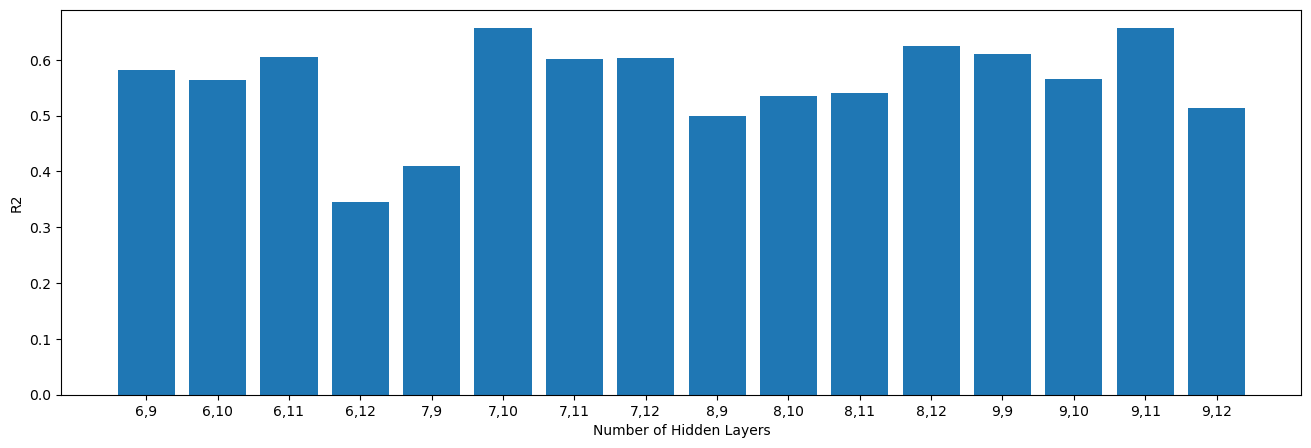

In [13]:
test2 = []
test3 = []

for x in range(6,10,1):
    for y in range(9, 13,1):
        result = SNN(x, y, False)
        print("Hidden Layer 1:", x, "Hidden Layer 2:", y," Max R2: ", result)
        hlayer_str = f"{x}" + "," + f"{y}"
        test2.append(result)
        test3.append(hlayer_str)

max_test_x = np.argmax(test2)
max_test_y = np.max(test2)
print("Best Number of Neurons:", max_test_x)

f = plt.figure(figsize=(16,5))
x_bar = np.array(test3)
y_bar = np.array(test2)

plt.bar(x_bar,y_bar)
plt.ylabel("R2")
plt.xlabel("Number of Hidden Layers")
plt.show()

## Troubleshoot

In [3]:
def SNN_ReLU(h_layer1, h_layer2, graph):
    X = pd.read_excel(root,usecols=[0,1,2,3,4])
    y = pd.read_excel(root,usecols=[6])
    
    # Normalize inputs
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y)
    
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float32)
    
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size = 0.33, random_state = 10)
    
    # Define the neural network
    class DeepNN(nn.Module):
        def __init__(self, input_size = 5, output_size = 1):
            super(DeepNN, self).__init__()
            self.fc1 = nn.Linear(input_size, h_layer1)
            self.fc2 = nn.Linear(h_layer1, h_layer2)
            self.out = nn.Linear(h_layer2, output_size)
    
            self.activation = nn.ReLU() 
    
        def forward(self, x):
            x = self.activation(self.fc1(x))
            x = self.activation(self.fc2(x))
            x = self.out(x)
            return x
    
    # Example instantiation
    model = DeepNN()
    
    # Loss function (Mean Squared Error for regression)
    criterion = nn.MSELoss()
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr = 0.01)
    
    num_epochs = 1000
    mse_train = []
    mse_test  = []
    
    mape_train = []
    mape_test  = []

    max_r2_test = []
    
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train)
        y_train_pred = model(X_train)
        y_test_pred = model(X_test)
        loss = criterion(y_train_pred, y_train)
    
        # Inverse from normalize
        y_train_r = scaler_y.inverse_transform(y_train.detach().numpy())
        y_train_pred_r = scaler_y.inverse_transform(y_train_pred.detach().numpy())
        y_test_r = scaler_y.inverse_transform(y_test.detach().numpy())
        y_test_pred_r = scaler_y.inverse_transform(y_test_pred.detach().numpy())
    
        # MAPE Calculation
        mape_train_epoch = mean_absolute_percentage_error(y_train_r, y_train_pred_r)*100
        mape_test_epoch = mean_absolute_percentage_error(y_test_r, y_test_pred_r)*100
    
        mape_train.append(mape_train_epoch)
        mape_test.append(mape_test_epoch)
    
        # Obtain Minimum MSE
        min_mape_train_x = np.argmin(mape_train)
        min_mape_train_y = np.min(mape_train)
        min_mape_test_x = np.argmin(mape_test)
        min_mape_test_y = np.min(mape_test)
    
        max_mape_train_y = np.max(mape_train)
        max_mape_test_y = np.max(mape_test)

        var_test  = r2_score(y_test.data.numpy(), y_test_pred.detach().numpy())
        max_r2_test.append(var_test)
        max_r2_test_score = np.max(max_r2_test)
    
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        var_train = r2_score(y_train.data.numpy(), y_train_pred.detach().numpy())
        var_test  = r2_score(y_test.data.numpy(), y_test_pred.detach().numpy())
    
        if (epoch+1) % 100 == 0 & graph == True:
            print(f"Epoch {epoch+1}/{num_epochs}") #, Training Loss: {loss.item():.4f}
            print("Train R²: ", "%.5f" % round(var_train, 5),"  Train MAPE: ", mape_train_epoch)
            print("Test R² : ", "%.5f" % round(var_test, 5),"  Test MAPE:  ", mape_test_epoch)
            
            fig, axes = plt.subplots(1, 2, figsize = (8,3))
            axes[0].scatter(y_train_r, y_train_pred_r)
            axes[0].plot([min(y_train_r), max(y_train_r)],[min(y_train_r), max(y_train_r)], color = 'r')
            axes[0].set_title("Training Data")
            axes[0].set_xlabel("Actual values")
            axes[0].set_ylabel("Predicted values")
    
            axes[1].scatter(y_test_r, y_test_pred_r)
            axes[1].plot([min(y_test_r), max(y_test_r)],[min(y_test_r), max(y_test_r)], color = 'r')
            axes[1].set_title("Test Data")
            axes[1].set_xlabel("Actual values")
            axes[1].set_ylabel("Predicted values")
            
            f = plt.figure(figsize=(8,5))
            plt.plot(mape_train, label = "Train MAPE")
            plt.plot(mape_test , label = "Test MAPE")
            plt.ylabel("Mean Absolute Percentage Error (%)")
            plt.xlabel("Epoch")
            plt.scatter(min_mape_train_x, min_mape_train_y,c= 'b', label='Minimum MAPE Train')
            plt.scatter(min_mape_test_x, min_mape_test_y,c= 'r', label='Minimum MAPE Test')
            plt.text(epoch * 0.2 , max_mape_train_y * 0.95, f"Train MAPE: {round(min_mape_train_y, 2)}%, Epoch: {min_mape_train_x}", 
                     bbox=dict(boxstyle="square,pad=0.3", fc="lightblue"))
            plt.text(epoch * 0.2 , max_mape_train_y * 0.8, f"Test MAPE: {round(min_mape_test_y, 2)}%, Epoch: {min_mape_test_x}",
                     bbox=dict(boxstyle="square,pad=0.3", fc="orange"))
            plt.legend()
    
            plt.draw();plt.pause(0.05)
        
        plt.ioff()
        plt.show()

    return max_r2_test_score

Hidden Layer 1: 6 Hidden Layer 2: 9  Max R2:  0.5509499292462452
Hidden Layer 1: 6 Hidden Layer 2: 10  Max R2:  0.18163615542160894
Hidden Layer 1: 6 Hidden Layer 2: 11  Max R2:  0.5539345405960732
Hidden Layer 1: 6 Hidden Layer 2: 12  Max R2:  0.7591982827397343
Hidden Layer 1: 7 Hidden Layer 2: 9  Max R2:  0.4174962492550458
Hidden Layer 1: 7 Hidden Layer 2: 10  Max R2:  0.4425005171165024
Hidden Layer 1: 7 Hidden Layer 2: 11  Max R2:  0.3887639186538544
Hidden Layer 1: 7 Hidden Layer 2: 12  Max R2:  0.6622390328545726
Hidden Layer 1: 8 Hidden Layer 2: 9  Max R2:  0.25870629355220565
Hidden Layer 1: 8 Hidden Layer 2: 10  Max R2:  0.3728699651364734
Hidden Layer 1: 8 Hidden Layer 2: 11  Max R2:  0.43296426824084555
Hidden Layer 1: 8 Hidden Layer 2: 12  Max R2:  0.3234927067927833
Hidden Layer 1: 9 Hidden Layer 2: 9  Max R2:  0.5227006208398597
Hidden Layer 1: 9 Hidden Layer 2: 10  Max R2:  0.5470465193086429
Hidden Layer 1: 9 Hidden Layer 2: 11  Max R2:  0.4834431306604473
Hidden Laye

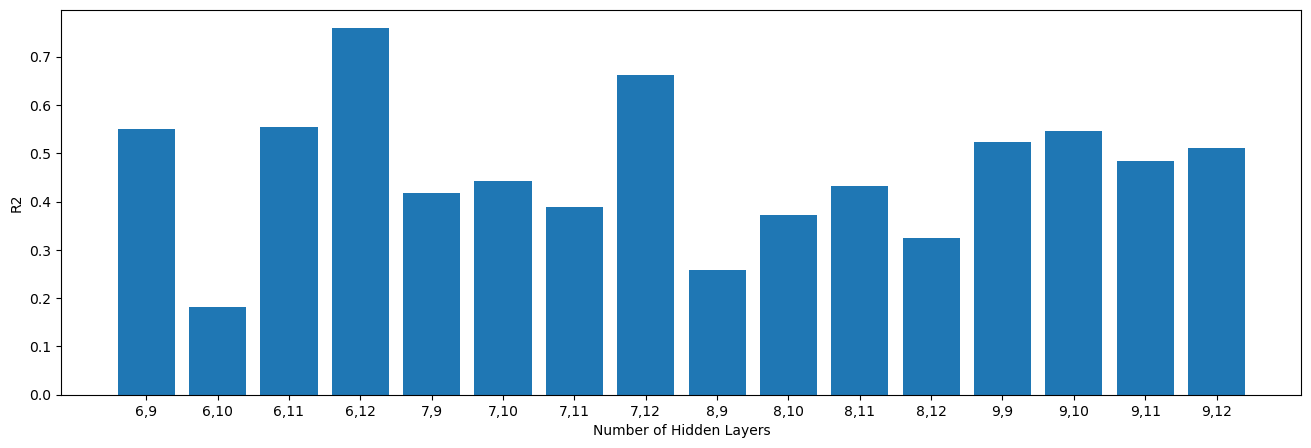

In [5]:
test4 = []
test5 = []

for x in range(6,10,1):
    for y in range(9, 13,1):
        result = SNN_ReLU(x, y, False)
        print("Hidden Layer 1:", x, "Hidden Layer 2:", y," Max R2: ", result)
        hlayer_str = f"{x}" + "," + f"{y}"
        test4.append(result)
        test5.append(hlayer_str)

f = plt.figure(figsize=(16,5))
x_bar = np.array(test5)
y_bar = np.array(test4)

plt.bar(x_bar,y_bar)
plt.ylabel("R2")
plt.xlabel("Number of Hidden Layers")
plt.show()